In [1]:
# import the libraries
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import keras_tuner as kt

In [2]:
# Load preprocessed dataset containing feature data and labels
data_dict = pickle.load(open('./data.pickle', 'rb'))

In [3]:
# Ensure each sample has 42 features (pad or truncate as necessary)
required_feature_length = 42
padded_data = []

for features in data_dict['data']:
    if len(features) > required_feature_length:
        features = features[:required_feature_length]  # Truncate if longer than 42
    elif len(features) < required_feature_length:
        features = features + [0] * (required_feature_length - len(features))  # Pad if shorter than 42
    padded_data.append(features)

data = np.asarray(padded_data)
labels = np.asarray(data_dict['labels'])

In [4]:
# Convert labels to one-hot encoding (for multi-class classification)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [5]:
# Check the shape of the data
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

Data shape: (960, 42), Labels shape: (960, 10)


In [6]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, shuffle=True, stratify=labels
)

In [7]:
# Reshape the data for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [8]:
# Build the RNN model (LSTM)
model = Sequential()

# LSTM layer
model.add(LSTM(64, input_shape=(x_train.shape[1], 1), activation='relu', return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(128, activation='relu'))
model.add(Dense(labels.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Reshape x_train to 3D for LSTM: (samples, timesteps, features)
x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  # Assuming 1 timestep per feature

In [10]:
# Train the model
history = model.fit(x_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.0992 - loss: 2.3005 - val_accuracy: 0.0990 - val_loss: 2.2622
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.1233 - loss: 2.2029 - val_accuracy: 0.2396 - val_loss: 2.1414
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.2213 - loss: 2.0538 - val_accuracy: 0.4271 - val_loss: 1.8262
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.1974 - loss: 2.1142 - val_accuracy: 0.0990 - val_loss: 2.2366
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1491 - loss: 2.1474 - val_accuracy: 0.2708 - val_loss: 1.6875
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.2127 - loss: 1.8704 - val_accuracy: 0.3177 - val_loss: 1.7202
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.2814 - loss: 1.9067 - val_accuracy: 0.1719 - val_loss: 2.1959
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1768 - loss: 2.2067 - val_accuracy: 0.1406 - v

In [11]:
# Evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)

print(f'Training accuracy: {train_acc * 100}%')
print(f'Testing accuracy: {test_acc * 100}%')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2224 - loss: 1.8272
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2097 - loss: 1.8343
Training accuracy: 23.30729216337204%
Testing accuracy: 23.95833283662796%


In [12]:
# Confusion Matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0]
 [20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0 10  2]
 [19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0]
 [20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  7  3]
 [11  0  0  5  0  0  0  0  3  1]]


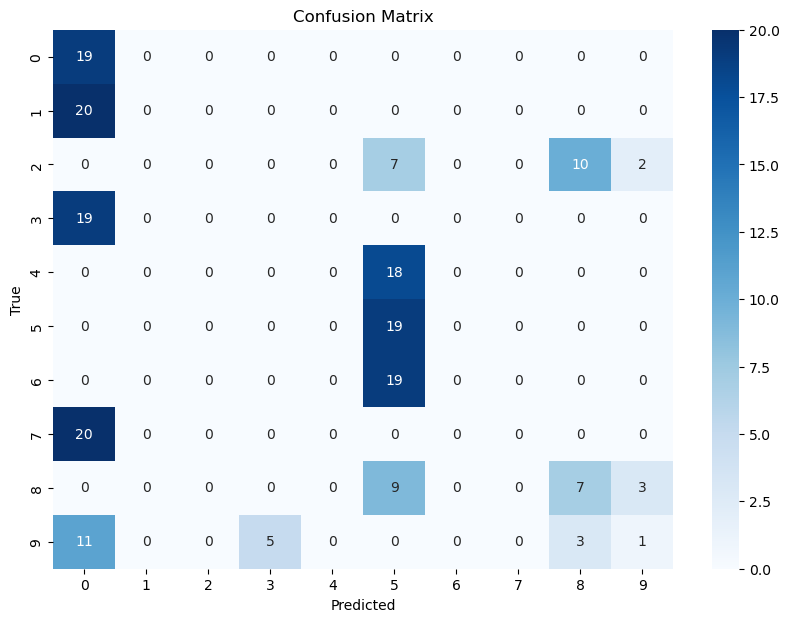

In [13]:
# Plot confusion matrix
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

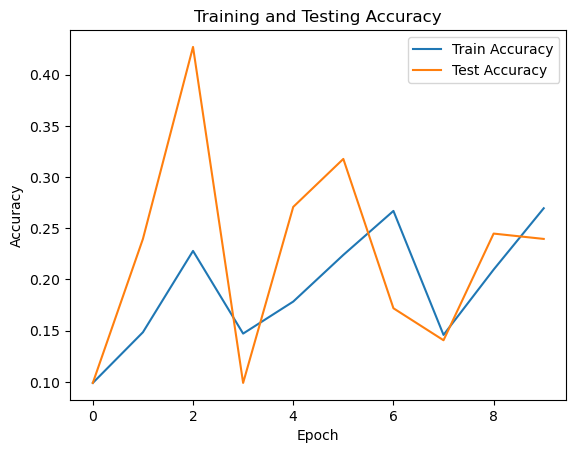

In [14]:
# Plot training and testing accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

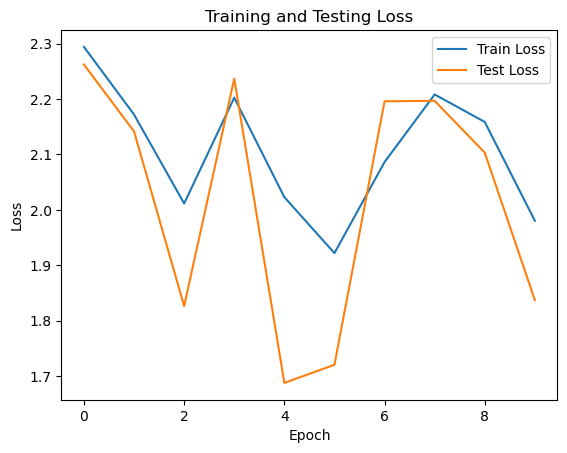

In [15]:
# Plot training and testing loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Hyperparameter Tuning

In [18]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Hyperparameter tuning function
def build_model(hp):
    model = Sequential()

    # LSTM Layer 1
    model.add(LSTM(
        hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
        input_shape=(x_train_reshaped.shape[1], 1),
        activation='relu',
        return_sequences=True
    ))
    model.add(Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout layer

    # LSTM Layer 2
    model.add(LSTM(
        hp.Int('lstm_units_2', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate_2', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout layer

    # Fully connected Dense Layer
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=128, step=32), activation='relu'))

    # Output layer with softmax activation for multi-class classification
    model.add(Dense(labels.shape[1], activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Set up the Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    hyperband_iterations=4,
    directory='keras_tuner',
    project_name='hand_sign_language',
    overwrite=True  # Set overwrite to True to overwrite previous trials
)


C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Search for the best hyperparameters
tuner.search(x_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Trial 360 Complete [00h 02m 33s]
val_accuracy: 0.8645833134651184

Best val_accuracy So Far: 0.9427083134651184
Total elapsed time: 07h 36m 07s


In [20]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [21]:
# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9599 - loss: 0.1694
Test Loss:  0.196949765086174
Test Accuracy:  0.9427083134651184


In [22]:
best_hyperparameters = tuner.oracle.get_best_trials()[0].hyperparameters.values

print("Best hyperparameters: ", best_hyperparameters)

Best hyperparameters:  {'lstm_units_1': 96, 'dropout_rate_1': 0.4, 'lstm_units_2': 64, 'dropout_rate_2': 0.2, 'dense_units': 64, 'learning_rate': 0.0006441763851228473, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}


In [ ]:
# pip install keras-tuner

In [ ]:
# # Define a function to build the model (used by Keras Tuner)
# def build_model(hp):
#     model = Sequential()

#     # Tune the number of LSTM units
#     model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
#                    input_shape=(x_train.shape[1], 1), 
#                    activation='relu', 
#                    return_sequences=True))
#     model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))  # Tune dropout rate
#     model.add(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'))
#     model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
#     # Tune the number of units in the dense layer
#     model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=128, step=64), activation='relu'))
#     model.add(Dense(labels.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class

#     # Tune the learning rate
#     model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')), 
#                   loss='categorical_crossentropy', 
#                   metrics=['accuracy'])
    
#     return model

# # Initialize the Keras Tuner
# tuner = kt.Hyperband(build_model, 
#                      objective='val_accuracy', 
#                      max_epochs=10, 
#                      hyperband_iterations=2, 
#                      directory='keras_tuner', 
#                      project_name='hand_sign_language')

# # Search for the best hyperparameters
# tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=32)

In [ ]:
print("Number of unique classes in y_train:", len(np.unique(y_train)))

In [ ]:
print(np.unique(labels))
print(len(np.unique(labels)))

In [ ]:
# import keras_tuner as kt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense
# from tensorflow.keras.optimizers import Adam

# # Hyperparameter tuning function
# def build_model(hp):
#     model = Sequential()

#     # LSTM Layer 1
#     model.add(LSTM(
#         hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
#         input_shape=(x_train_reshaped.shape[1], 1),
#         activation='relu',
#         return_sequences=True
#     ))
#     model.add(Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout layer

#     # LSTM Layer 2
#     model.add(LSTM(
#         hp.Int('lstm_units_2', min_value=64, max_value=256, step=64),
#         activation='relu'
#     ))
#     model.add(Dropout(hp.Float('dropout_rate_2', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout layer

#     # Fully connected Dense Layer
#     model.add(Dense(hp.Int('dense_units', min_value=64, max_value=128, step=32), activation='relu'))

#     # Output layer with softmax activation for multi-class classification
#     model.add(Dense(labels.shape[1], activation='softmax'))

#     # Compile the model
#     model.compile(
#         optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

# # # Set up the tuner
# # tuner = kt.RandomSearch(
# #     build_model, 
# #     objective='val_accuracy',  # Objective to optimize
# #     max_trials=15,  # Number of trials to search
# #     executions_per_trial=3,  # Number of executions per trial (to average results)
# #     directory='my_dir',  # Directory to save results
# #     project_name='lstm_tuning'
# # )
# tuner = kt.Hyperband(build_model, 
#                     objective='val_accuracy',  # Objective to optimize
#                     max_epochs=10,  # Max epochs per trial
#                     hyperband_iterations=2,  # Number of Hyperband iterations
#                     directory='keras_tuner',  # Directory to store results
#                     project_name='hand_sign_language'  # Project name
#                     )

# # Search for the best hyperparameters
# tuner.search(x_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

In [ ]:
# # Get the best models
# best_models = tuner.get_best_models()
# best_model = best_models[0]

# # Print the best hyperparameters
# best_hyperparameters = tuner.oracle.get_best_trials()[0].hyperparameters
# print("Best Hyperparameters: ", best_hyperparameters)

# # Evaluate the best model
# best_model.evaluate(x_test, y_test)

In [ ]:
# # Get the best model and hyperparameters
# best_model = tuner.get_best_models()[0]
# best_hyperparameters = tuner.oracle.get_best_trials()[0].hyperparameters.values

# print("Best hyperparameters: ", best_hyperparameters)

In [23]:
# Evaluate the best model
train_loss, train_acc = best_model.evaluate(x_train, y_train)
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print(f'Training accuracy: {train_acc * 100}%')
print(f'Testing accuracy: {test_acc * 100}%')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9399 - loss: 0.1754
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9599 - loss: 0.1694
Training accuracy: 95.44270634651184%
Testing accuracy: 94.27083134651184%


In [24]:
# Confusion Matrix
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  2  0  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  9  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 20]]


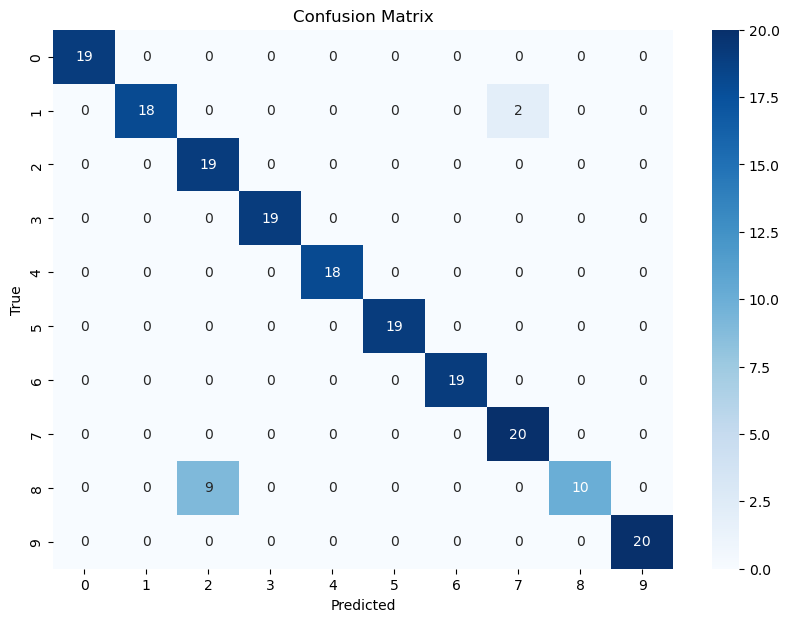

In [25]:
# Plot confusion matrix
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Save the best model
best_model.save('best_model.h5')

print("Best model saved to 'best_model.h5'")

Best model saved to 'best_model.h5'
